# Prototype: Bank Churn Classification

## Library Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import lightgbm as lgb
import optuna
import logging
import sys
import joblib
import datetime

from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import QuantileTransformer, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.utils.class_weight import compute_sample_weight
from sklearn import metrics

E:\Current_Workdir\Portfolios\End-to-End-Machine-Learning-Project-Bank-Churn-Prediction\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Loading & Cleaning

Data loading

In [2]:
path = '../data/Churn_Modelling.csv'

In [3]:
churn = pd.read_csv(path)
churn

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,3,15619304,Onio,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,1
3,4,15701354,Boni,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43.0,2,125510.82,1,NaN,1.0,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9997,9998,15584532,Liu,709,France,Female,36.0,7,0.00,1,0.0,1.0,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,1
9999,9999,15682355,Sabbatini,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,1
10000,10000,15628319,Walker,792,France,Female,28.0,4,130142.79,1,1.0,0.0,38190.78,0


Set 'CustomerId' as row index

In [4]:
churn = churn.set_index('CustomerId')

Drop rownumber

In [5]:
churn = churn.drop('RowNumber', axis=1)

Check if CustomerId is unique (check if one person appears multiple times)

In [6]:
churn.index.is_unique

False

It seems that the Customer ID is not unique, and based on the preview above we can also see that the original data sometimes contains two identical record at different rows. It is indicative of a double entry mistake, and we will correct it by only selecting the unique values.

Fixing double entry mistakes by dropping duplicates

In [7]:
churn = churn.drop_duplicates()

## Missing Value Checks

Based on some of the data preview we saw above, we can see that there are some NaNs laying around, we will find out how much missing values are in this database and their correlation

Total Number of missing values per column

In [8]:
churn.isnull().sum()

Surname            0
CreditScore        0
Geography          1
Gender             0
Age                1
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          1
IsActiveMember     1
EstimatedSalary    0
Exited             0
dtype: int64

It seems like there is only a row missing, barely enough to make a trouble, but to be thorough let's visualize it with missingno

Number of missing data visualization

<Axes: >

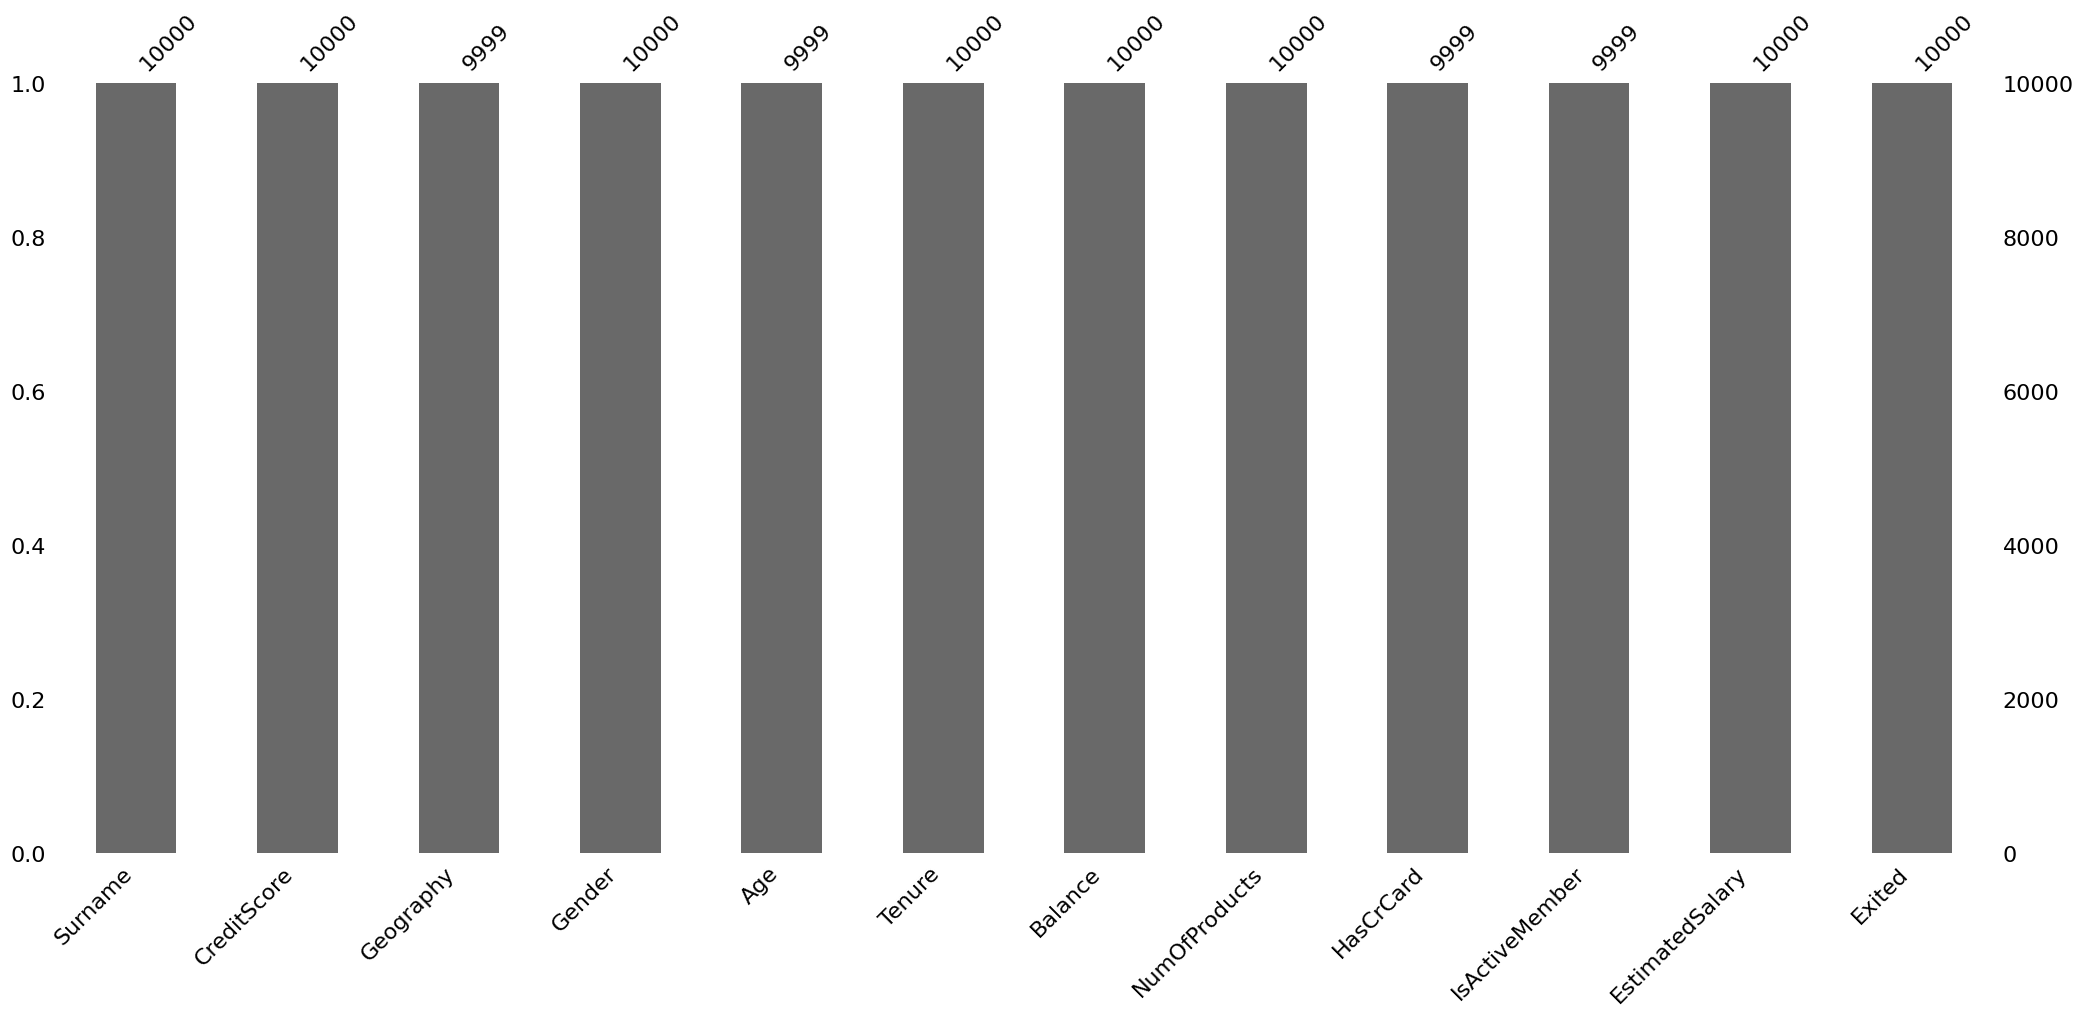

In [9]:
msno.bar(churn)

Based on the plot, it seems like there really is only 1 to 4 missing rows, let's use look at those missing rows

In [10]:
miss_subset = churn[churn.isnull().any(axis=1)]
miss_subset

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CustomerId,,,,,,,,,,,,
15737888,Mitchell,850,Spain,Female,43.0,2,125510.82,1,NaN,1.0,79084.10,0
15592531,Bartlett,822,NaN,Male,50.0,7,0.00,2,1.0,1.0,10062.80,0
15792365,He,501,France,Male,44.0,4,142051.07,2,0.0,NaN,74940.50,0
15592389,H?,684,France,Male,NaN,2,134603.88,1,1.0,1.0,71725.73,0


It is correct, there is only 4

### Data Loading & Cleaning

alright, thus far we have found and done the following to the data:
1. The CustomerId is originally not unique, there seems to be double input
2. We deduplicate the CustomerId and set it as row index
3. We deleted the RowNumber as it is uninformative
4. We found that there is exactly 4 rows with missing columns

## Exploratory Data Analysis

In [11]:
categorical_features = churn.select_dtypes(include=['object'])
numerical_features = churn.select_dtypes(include=['number'])
numerical_features = numerical_features.drop('Exited', axis=1)

### Summary Statistics

#### Categorical Variables

In [12]:
categorical_features.describe()

,Surname,Geography,Gender
count,10000,9999,10000
unique,2932,3,2
top,Smith,France,Male
freq,32,5013,5457


#### Numerical Variables

In [13]:
numerical_features.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,10000.000000,9999.000000,10000.000000,10000.000000,10000.000000,9999.000000,9999.000000,10000.000000
mean,650.528800,38.923095,5.012800,76485.889288,1.530200,0.705471,0.515052,100090.239881
std,96.653299,10.487635,2.892174,62397.405202,0.581654,0.455854,0.499798,57510.492818
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.000000,0.000000,51002.110000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.000000,1.000000,100193.915000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.000000,1.000000,149388.247500
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000


## Plot of Categorical Variables

C:\Users\comp4\AppData\Local\Temp\ipykernel_21276\3180222980.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(data = churn, x=i, y='Exited', kind = "bar", palette='mako').set(title=i)
C:\Users\comp4\AppData\Local\Temp\ipykernel_21276\3180222980.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(data = churn, x=i, y='Exited', kind = "bar", palette='mako').set(title=i)


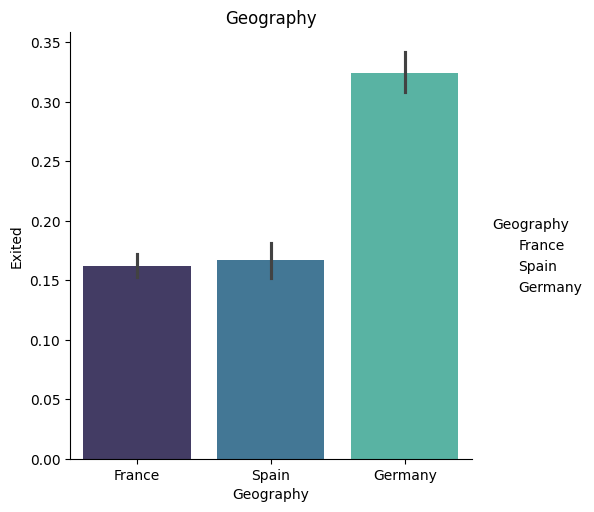

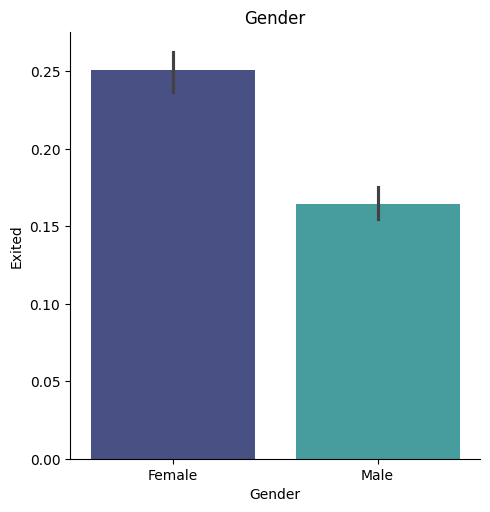

In [14]:
for i in categorical_features.drop('Surname', axis = 1).columns:
    sns.catplot(data = churn, x=i, y='Exited', kind = "bar", palette='mako').set(title=i)

C:\Users\comp4\AppData\Local\Temp\ipykernel_21276\3903609626.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(data = churn, x='Surname', y='Exited', kind = "bar", palette='mako', order=Exited_True.Surname.value_counts().iloc[:10].index, aspect=2).set(title="Top 10 Surnames who churned")


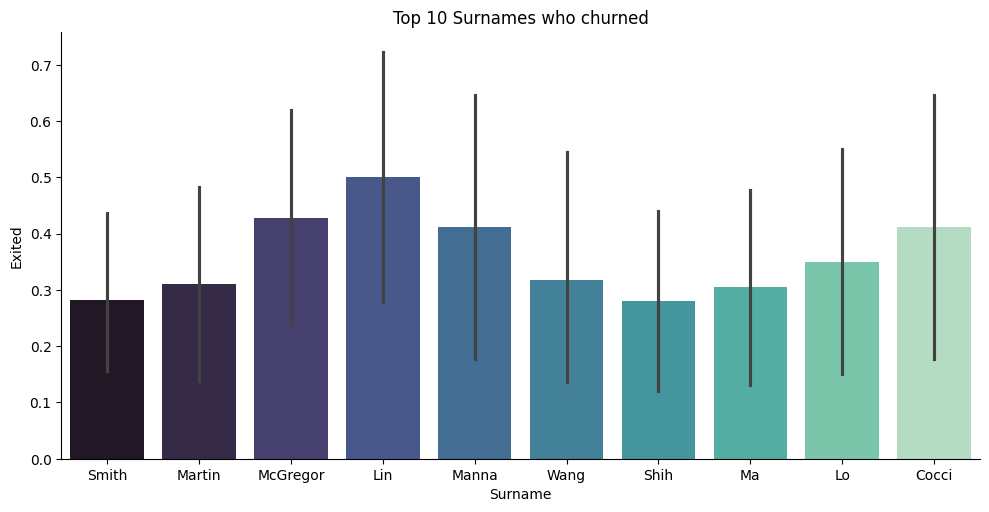

In [15]:
# Plot of top 10 surnames who churned
Exited_True = churn[churn['Exited']==1]
sns.catplot(data = churn, x='Surname', y='Exited', kind = "bar", palette='mako', order=Exited_True.Surname.value_counts().iloc[:10].index, aspect=2).set(title="Top 10 Surnames who churned")

In [16]:
churn[['Surname', 'Exited']].groupby('Surname').value_counts().sort_values(ascending = False)

Surname    Exited
Scott      0         26
Walker     0         24
Smith      0         23
Yeh        0         22
Genovese   0         21
                     ..
McCane     0          1
McCall     0          1
McCaffrey  0          1
McBurney   0          1
Kruglov    1          1
Name: count, Length: 3804, dtype: int64

### Distribution Plot of Numerical Variables

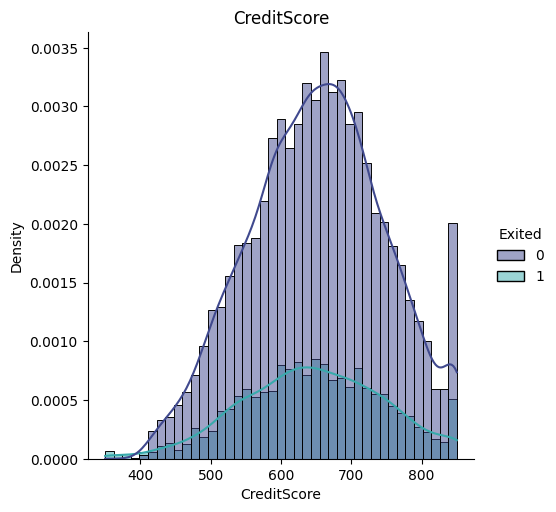

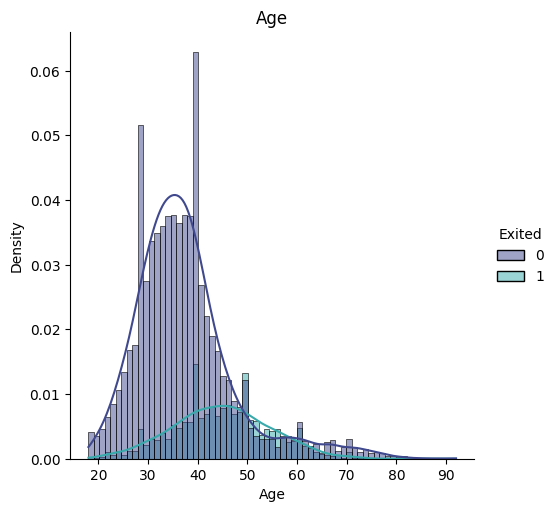

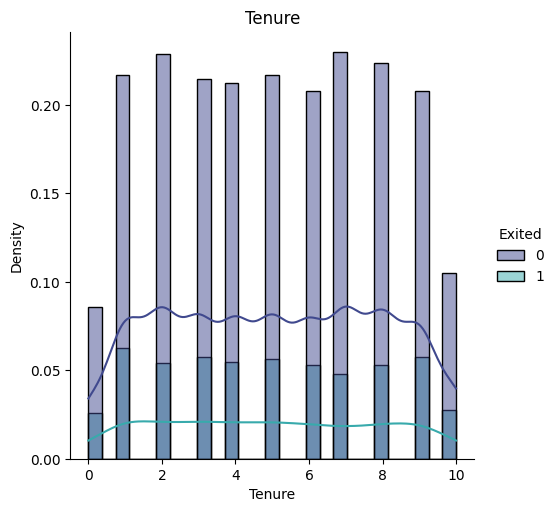

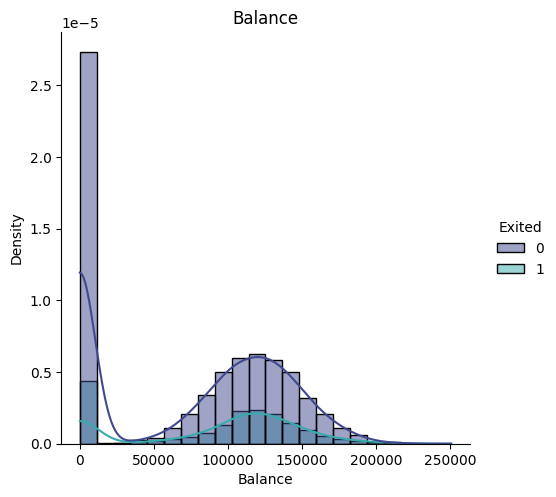

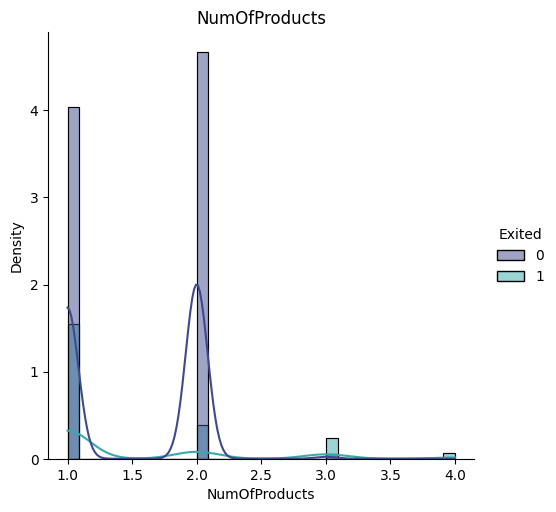

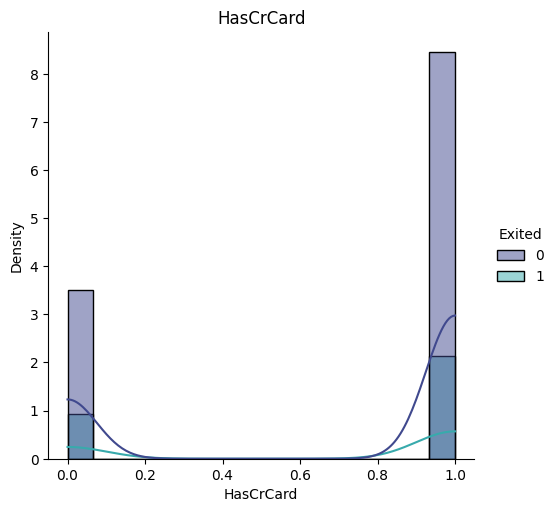

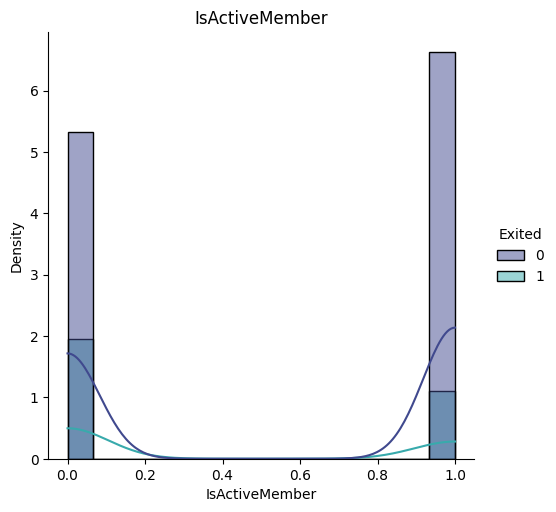

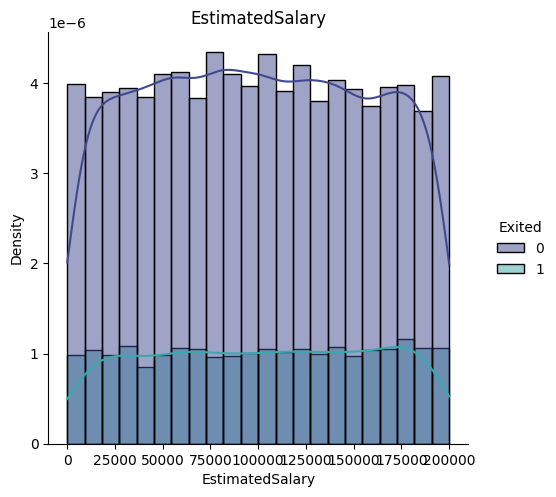

In [17]:
for i in numerical_features.columns:
    sns.displot(data=churn, x=i, hue='Exited', stat='density',palette='mako', kde=True).set(title=i)

### Box Plots of Numerical Variables

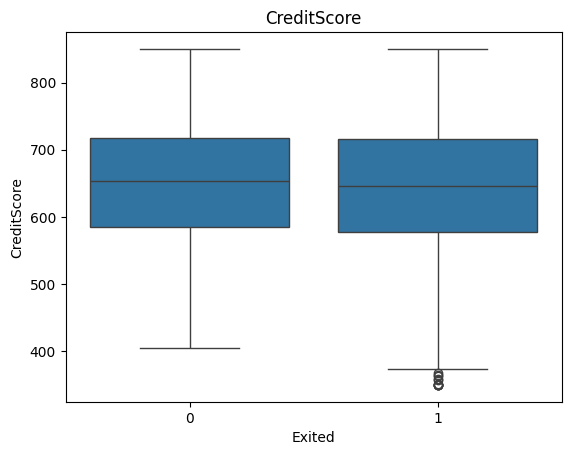

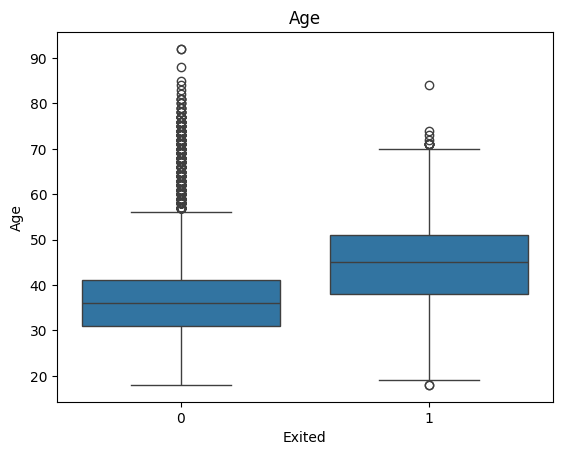

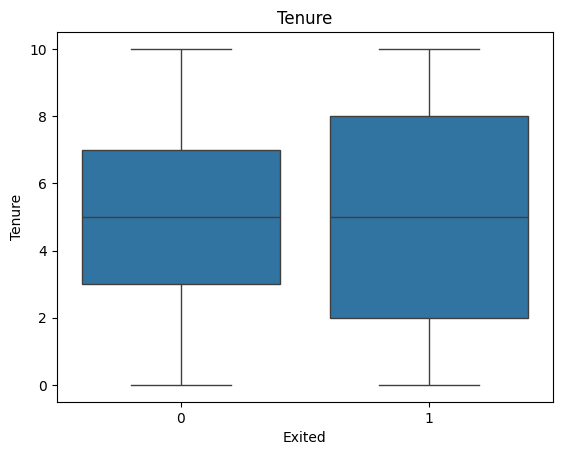

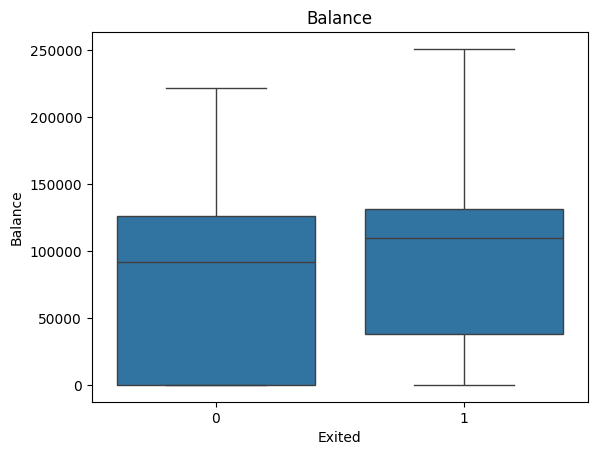

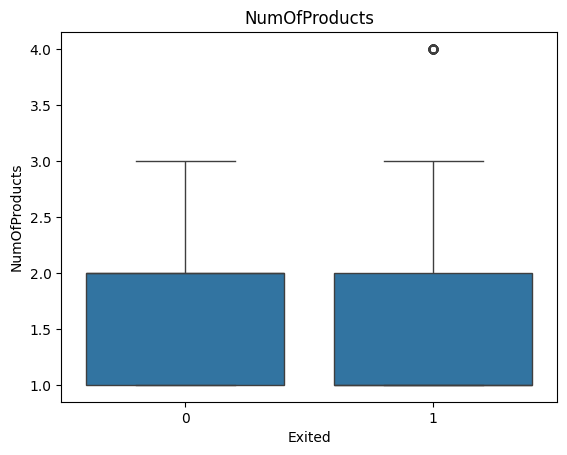

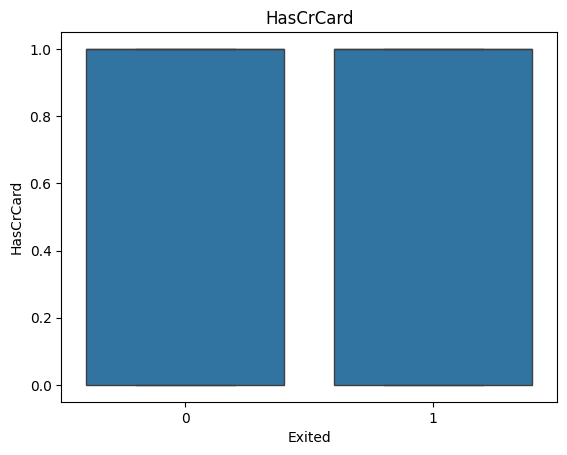

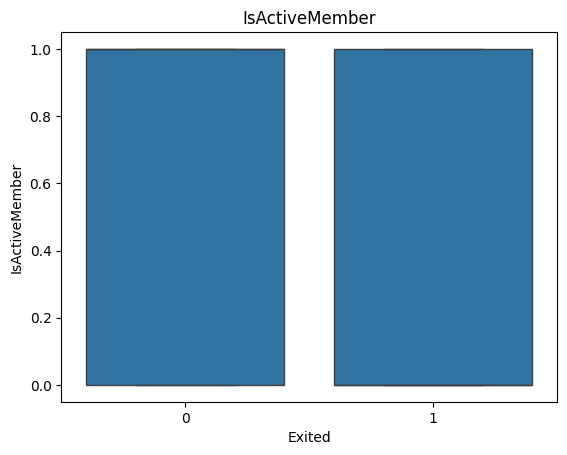

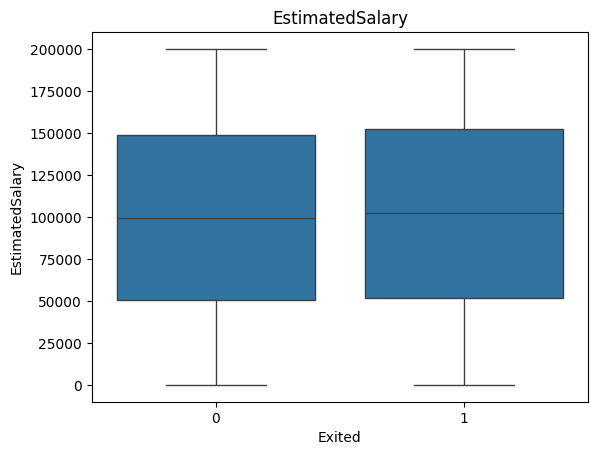

In [18]:
for i in numerical_features.columns:
    plt.figure()
    sns.boxplot(data=churn, x='Exited', y=i)
    plt.title(i)

### Correlation Plot of Numerical Variables

In [19]:
corr = numerical_features.corr()
corr.style.background_gradient(cmap='coolwarm')

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
CreditScore,1.000000,-0.003923,0.000842,0.006268,0.012238,-0.005593,0.025806,-0.001384
Age,-0.003923,1.000000,-0.010117,0.028415,-0.030790,-0.011673,0.085548,-0.007248
Tenure,0.000842,-0.010117,1.000000,-0.012254,0.013444,0.022652,-0.028330,0.007784
Balance,0.006268,0.028415,-0.012254,1.000000,-0.304180,-0.014910,-0.010187,0.012797
NumOfProducts,0.012238,-0.030790,0.013444,-0.304180,1.000000,0.003242,0.009534,0.014204
HasCrCard,-0.005593,-0.011673,0.022652,-0.014910,0.003242,1.000000,-0.011781,-0.009910
IsActiveMember,0.025806,0.085548,-0.028330,-0.010187,0.009534,-0.011781,1.000000,-0.011380
EstimatedSalary,-0.001384,-0.007248,0.007784,0.012797,0.014204,-0.009910,-0.011380,1.000000


### Proportion of Target Variables

In [20]:
churn.Exited.value_counts()

Exited
0    7963
1    2037
Name: count, dtype: int64

as a percentage

In [21]:
churn.Exited.value_counts(normalize=True)

Exited
0    0.7963
1    0.2037
Name: proportion, dtype: float64

### EDA Summary
1. Most people who churn are from Germany
2. Most people who churn are woman
3. Based on descriptive analysis and the author's prior knowledge, the surnames can be divided to Anglophonic (Smith, Martin, McGregor), Latin (Romeo, Delucci, Marcelo), Asian (Wang, Ma, Lo), Slavic(Vasilliev, Chesnokova, Zuyev), Germanic (Schneider, Steinhoff), or African (Nwokezuike, Oguejiofor, Ugochukwu)
4. Top 10 most common churner surnames are either anglophonic or asian
5. The variable creditscore, age, and numofproduct contains outlier
6. Those who churn are on average older, has more product, has a credit card, and is not an active member
7. The target variable suffers some imbalance with negative class at about 80% of all data and positive class at only 20%
8. None of the numerical data are highly correlated with each-other

## Feature Engineering

##### Pipeline Definition
We will build our data processing pipeline to do the following:  
- we will split data into training/testing split with 75/25 proportions stratified (due to the class imbalance)
- We will impute all the column with missing values using knn imputation for numeric and mode imputer for categoric
- We will one-hot encode the variable Geography and Gender
- We saw that the variable surname doesn't always reflect the geography due to immigration, therefore surname might actually contain valuable information as well. However, due to the fact that there are 2932 unique name, if we use one-hot encoding, it will create a very sparse data that is hard to learn by most estimator / model. In order to circumvent that we will use tfidfvectorizer with analyze='char' to vectorize it at a character level (surnames are only 1 word), then we will reduce the dimensionality of the vector to 10 using SVD (Support Vector Decomposition), based on our observation that there are 6 language group present in the surnames (we give an extra in case there is an a language-family that i didn't catch). This method is similar to LSA (Latent Semantic Analysis) embedding, the difference being that LSA usually vectorizes the sentence at word level.
- The variable creditscore, age and numofproduct all have outliers, in order to limit it's impact we will normalize and scale it using a method that is robust to outlier, which is quantileTransformer which implements quantile normalization
- For the variable tenure, balance, estimatedsalary, even though contains no outlier, is still far from normal, some model such as SVM, KNN, and MLP have trouble with unnormalized data, so just in case we will also normalize and scale them with quantile normalization transform
- We will leave variable HasCrCard and IsActiveMember unchanged as it is already in desired format
- The target suffers from imbalance, in a classification setting this might cause a low F1 score (specifically a precision that is drastically lower than the recall). In order to counter this, we will add class weight to the estimator (random forest & lightgbm)

### Data Split

In [22]:
X = churn.iloc[:, :-1]
y = churn.iloc[:, -1]

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=7)

### Missing Value Imputation

In [24]:
def custom_imputation(churn, X_train, X_test):
    categorical_cols = churn.select_dtypes(include=['object']).columns.tolist()
    numeric_cols = churn.select_dtypes(include=['number']).columns.tolist()[:-1]
    train_index = X_train.index
    test_index = X_test.index

    imputation_pipeline = ColumnTransformer(
        transformers=[
            ('simple_imputer_categorical', SimpleImputer(strategy="most_frequent"), categorical_cols),
            ('knn_imputer_numerical', KNNImputer(), numeric_cols)
        ]
    )
    
    X_train = imputation_pipeline.fit_transform(X_train)
    X_test = imputation_pipeline.transform(X_test)

    X_train = pd.DataFrame(X_train, columns=categorical_cols + numeric_cols, index=train_index)
    X_test = pd.DataFrame(X_test, columns=categorical_cols + numeric_cols, index=test_index)
    
    return (X_train, X_test)

In [25]:
X_train, X_test = custom_imputation(churn, X_train, X_test)

### Text-Embedding Pipeline

In [26]:
lsa_embedding = Pipeline(
   [
        ('tf-idf_vectorizer', TfidfVectorizer(analyzer="char")),
        ("truncated_SVD", TruncatedSVD(n_components=10))
   ]
)

### Preprocessing Pipeline: Encoding For Categorical Variables, Normalization for Numerical Variables, and LSA-style Embedding for Text Variables

In [27]:
preprocess_pipeline = ColumnTransformer(
    transformers=[
        ('lsa_embedding', lsa_embedding, 'Surname'),
        ('quantile_normal_transform', QuantileTransformer(output_distribution='normal'), ['CreditScore', 'Age', 'NumOfProducts', 'Tenure','EstimatedSalary', 'Balance']),
        ('one_hot_encoding', OneHotEncoder(handle_unknown='ignore'), ['Geography', 'Gender'])
    ], remainder='passthrough'
)

In [28]:
preprocess_pipeline

ColumnTransformer(remainder='passthrough',
                  transformers=[('lsa_embedding',
                                 Pipeline(steps=[('tf-idf_vectorizer',
                                                  TfidfVectorizer(analyzer='char')),
                                                 ('truncated_SVD',
                                                  TruncatedSVD(n_components=10))]),
                                 'Surname'),
                                ('quantile_normal_transform',
                                 QuantileTransformer(output_distribution='normal'),
                                 ['CreditScore', 'Age', 'NumOfProducts',
                                  'Tenure', 'EstimatedSalary', 'Balance']),
                                ('one_hot_encoding',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['Geography', 'Gender'])])

### Summary Thus Far
Defined pipeline consisting of:
- Splitting data into training-testing set with proportion 75-25
- LSA-style (TF-IDF + SVD) text embedding for the variable 'Surname'
- Quantile Normal Transformation for 'CreditScore', 'Age', 'NumOfProducts', 'Tenure', 'EstimatedSalary', 'Balance'
- One-hot encoding for 'Geography', 'Gender'
- Nothing for 'HasCrCard', 'IsActiveMember'

## Modeling

### Check Model Parameters

The model we will be using are random forest and gradient boosting. The reasoning behind this lies in the fact that according to recent [research](https://arxiv.org/pdf/2207.08815.pdf) tree based models still beat novel NN-based method on benchmarks. Furthermore, these tree based models provide (random forest and gradient boosting) methods to overcome imbalance via class and error weights, reducing the need to use resource heavy data sampling method such as SMOTE or ADASYN, which blows up the memory, hence a lot more scaleable. LightGBM is chosen instead of XGBoost's or sklearn's gradientboosting due to it's [leafwise](https://datascience.stackexchange.com/questions/26699/decision-trees-leaf-wise-best-first-and-level-wise-tree-traverse) tree building algorithm, which is a lot faster, especially on CPU.

#### Random Forest Parameter

In [29]:
RandomForestClassifier().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

#### LightGBM Parameter

In [30]:
lgb.LGBMClassifier().get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

## Define Objective Function and Search Space for Hyperparameter Tuning

- Note that due to the fact that the target variable (Exited) is unbalanced, the objective function is set to maximize F1 score, this is due to the fact that F1 score will not hide the effect of imbalance as it is a harmonic mean of the precision and recall
- To counter this imbalance phenomenon we will utilize sample weights and class weights.
- For random forest, class weights is set using the class_weight parameter
- For lightgbm, class weights is set using the scale_pos_weight parameter that is calculated as num_negative_instance / num_positive_instance
- sample weights will be utilized for all
- while class weights will be set in the params

In [31]:
def objective(trial):
    sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
    scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
    
    clf = trial.suggest_categorical('classifier', ['rf', 'lgbm'])
    
    if clf == 'rf':
        
        bootstrap = trial.suggest_categorical('rf_model__bootstrap', [True, False])
        class_weight = trial.suggest_categorical('rf_model__class_weight',["balanced_subsample","balanced"])
        max_depth = trial.suggest_int('rf_model__max_depth', 2, churn.shape[1])
        max_features = trial.suggest_categorical('rf_model__max_features', ['sqrt', 'log2'])
        max_leaf_nodes = trial.suggest_int('rf_model__max_leaf_nodes', 5, 15)
        criterion = trial.suggest_categorical('rf_model__criterion',['gini', 'entropy'])
        n_estimators = trial.suggest_int('rf_model__n_estimators', 500, 1000)
        
        params = {
            'rf_model__bootstrap': bootstrap,
            'rf_model__class_weight': class_weight,
            'rf_model__max_depth': max_depth,
            'rf_model__max_features': max_features,
            'rf_model__max_leaf_nodes': max_leaf_nodes,
            'rf_model__criterion': criterion,
            'rf_model__n_estimators': n_estimators
        }
        
        clf_pipe = Pipeline(
            steps = [
                ('preprocessor', preprocess_pipeline),
                ('rf_model', RandomForestClassifier(random_state = 0, n_jobs = -1))
            ]
        )
        
        clf_pipe.set_params(**params)
        
        # balanced_accuracy = cross_val_score(clf_pipe, X_train, y_train, cv=5, scoring = 'balanced_accuracy', fit_params = {'rf_model__sample_weight': sample_weights}).mean()
        # auc = cross_val_score(clf_pipe, X_train, y_train, cv=5, scoring = 'roc_auc', fit_params = {'rf_model__sample_weight': sample_weights}).mean()
        # precision = cross_val_score(clf_pipe, X_train, y_train, cv=5, scoring = 'precision', fit_params = {'rf_model__sample_weight': sample_weights}).mean()
        # recall = cross_val_score(clf_pipe, X_train, y_train, cv=5, scoring = 'recall', fit_params = {'rf_model__sample_weight': sample_weights}).mean()
        # sensitivity = cross_val_score(clf_pipe, X_train, y_train, cv=5, scoring = 'recall', fit_params = {'rf_model__sample_weight': sample_weights}).mean()
        # specificity = cross_val_score(clf_pipe, X_train, y_train, cv=5, scoring = specificity_scorer, fit_params = {'rf_model__sample_weight': sample_weights}).mean()
        f1 = cross_val_score(clf_pipe, X_train, y_train, cv=5, scoring = 'f1', params = {'rf_model__sample_weight': sample_weights}).mean()
            
        return f1
    
    if clf == 'lgbm':
        
        colsample_bytree = trial.suggest_float('lgb_model__colsample_bytree', 0.5, 1)
        learning_rate = trial.suggest_loguniform('lgb_model__learning_rate', 0.001, 0.1)
        max_depth = trial.suggest_int('lgb_model__max_depth', 2, 20)
        num_leaves = trial.suggest_int('lgb_model__num_leaves', 20, 100)
        n_estimators = trial.suggest_int('lgb_model__n_estimators', 500, 1000)
        reg_alpha = trial.suggest_loguniform('lgb_model__reg_alpha', 0.001, 10)
        reg_lambda = trial.suggest_loguniform('lgb_model__reg_lambda', 0.001, 10)
        subsample = trial.suggest_float('lgb_model__subsample', 0.5, 1)
        pos_weight = trial.suggest_categorical('lgb_model__scale_pos_weight',[scale_pos_weight])
        
        params = {
            'lgb_model__colsample_bytree': colsample_bytree,
            'lgb_model__learning_rate': learning_rate,
            'lgb_model__max_depth': max_depth,
            'lgb_model__num_leaves': num_leaves,
            'lgb_model__n_estimators': n_estimators,
            'lgb_model__reg_alpha': reg_alpha,
            'lgb_model__reg_lambda': reg_lambda,
            'lgb_model__subsample': subsample,
            'lgb_model__scale_pos_weight':pos_weight
        }
        
        clf_pipe = Pipeline(
            steps = [
                ('preprocessor', preprocess_pipeline),
                ('lgb_model', lgb.LGBMClassifier(device="gpu", random_state = 0, objective='binary', verbose = -1))
            ]
        )
        clf_pipe.set_params(**params)
        
        # balanced_accuracy = cross_val_score(clf_pipe, X_train, y_train, cv=5, scoring = 'balanced_accuracy', fit_params = {'rf_model__sample_weight': sample_weights}).mean()
        # auc = cross_val_score(clf_pipe, X_train, y_train, cv=5, scoring = 'roc_auc', fit_params = {'rf_model__sample_weight': sample_weights}).mean()
        # precision = cross_val_score(clf_pipe, X_train, y_train, cv=5, scoring = 'precision', fit_params = {'rf_model__sample_weight': sample_weights}).mean()
        # recall = cross_val_score(clf_pipe, X_train, y_train, cv=5, scoring = 'recall', fit_params = {'rf_model__sample_weight': sample_weights}).mean()
        # sensitivity = cross_val_score(clf_pipe, X_train, y_train, cv=5, scoring = 'recall', fit_params = {'rf_model__sample_weight': sample_weights}).mean()
        # specificity = cross_val_score(clf_pipe, X_train, y_train, cv=5, scoring = specificity_scorer, fit_params = {'rf_model__sample_weight': sample_weights}).mean()
        f1 = cross_val_score(clf_pipe, X_train, y_train, cv=5, scoring = 'f1', params = {'lgb_model__sample_weight': sample_weights}).mean()
            
        return f1

In [32]:
#optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))

### Tune The Hyperparameters

In [33]:
sampler = optuna.samplers.TPESampler(seed=10)
study = optuna.create_study(direction='maximize', sampler = sampler, storage="sqlite:///db.sqlite3", study_name="bank_churn_prediction_rf_lgbm_imbalanced")  
study.optimize(objective, n_trials=10)  

[I 2024-02-19 20:26:01,894] A new study created in RDB with name: bank_churn_prediction_rf_lgbm_imbalanced
[I 2024-02-19 20:26:05,151] Trial 0 finished with value: 0.33850231453787466 and parameters: {'classifier': 'rf', 'rf_model__bootstrap': False, 'rf_model__class_weight': 'balanced_subsample', 'rf_model__max_depth': 4, 'rf_model__max_features': 'sqrt', 'rf_model__max_leaf_nodes': 5, 'rf_model__criterion': 'entropy', 'rf_model__n_estimators': 501}. Best is trial 0 with value: 0.33850231453787466.
C:\Users\comp4\AppData\Local\Temp\ipykernel_21276\1050991338.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lgb_model__learning_rate', 0.001, 0.1)
C:\Users\comp4\AppData\Local\Temp\ipykernel_21276\1050991338.py:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This f

#### Check best score and hyperparameter on the training data

In [34]:
print(f"Best Score (F1): {study.best_value}")
print(f"Best Parameters:\n {study.best_params}")

Best Score (F1): 0.6022580811423172
Best Parameters:
 {'classifier': 'lgbm', 'lgb_model__colsample_bytree': 0.5234481596946249, 'lgb_model__learning_rate': 0.01788851529448829, 'lgb_model__max_depth': 12, 'lgb_model__num_leaves': 86, 'lgb_model__n_estimators': 599, 'lgb_model__reg_alpha': 2.6754769258252624, 'lgb_model__reg_lambda': 0.025504132602413028, 'lgb_model__subsample': 0.8773238457649286, 'lgb_model__scale_pos_weight': 3.9083769633507854}


### Evaluate Best Parameter on Test Data

In [35]:
def eval_hyperparams(study, X_test, y_test, X_train, y_train):
    sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
    # scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
    
    if study.best_params['classifier'] == 'lgbm':
        
        params = {
            'lgb_model__colsample_bytree': study.best_params['lgb_model__colsample_bytree'],
            'lgb_model__learning_rate': study.best_params['lgb_model__learning_rate'],
            'lgb_model__max_depth': study.best_params['lgb_model__max_depth'],
            'lgb_model__num_leaves': study.best_params['lgb_model__num_leaves'],
            'lgb_model__n_estimators': study.best_params['lgb_model__n_estimators'],
            'lgb_model__reg_alpha': study.best_params['lgb_model__reg_alpha'],
            'lgb_model__reg_lambda': study.best_params['lgb_model__reg_lambda'],
            'lgb_model__subsample': study.best_params['lgb_model__subsample'],
            'lgb_model__scale_pos_weight': study.best_params['lgb_model__scale_pos_weight']
        }
        
        clf_pipe = Pipeline(
            steps = [
                ('preprocessor', preprocess_pipeline),
                ('lgb_model', lgb.LGBMClassifier(device="gpu", random_state = 0, objective='binary', verbose = -1))
            ]
        )
        
        clf_pipe.set_params(**params)
        clf_pipe.fit(X_train, y_train, lgb_model__sample_weight = sample_weights)
    
    if study.best_params['classifier'] == 'rf':
        
        params = {
            'rf_model__bootstrap': study.best_params['rf_model__bootstrap'],
            'rf_model__class_weight': study.best_params['rf_model__class_weight'],
            'rf_model__max_depth': study.best_params['rf_model__max_depth'],
            'rf_model__max_features': study.best_params['rf_model__max_features'],
            'rf_model__max_leaf_nodes': study.best_params['rf_model__max_leaf_nodes'],
            'rf_model__criterion': study.best_params['rf_model__criterion'],
            'rf_model__n_estimators': study.best_params['rf_model__n_estimators']
        }
        
        clf_pipe = Pipeline(
            steps = [
                ('preprocessor', preprocess_pipeline),
                ('rf_model', RandomForestClassifier(random_state = 0, n_jobs = -1))
            ]
        )
        
        clf_pipe.set_params(**params)
        clf_pipe.fit(X_train, y_train, rf_model__sample_weight = sample_weights)
        
    
        
    pred = clf_pipe.predict(X_test)

    accuracy = metrics.accuracy_score(pred, y_test)
    balanced_accuracy = metrics.balanced_accuracy_score(pred, y_test)
    auc = metrics.roc_auc_score(pred, y_test)
    f1 = metrics.f1_score(pred, y_test)
    precision = metrics.precision_score(pred, y_test)
    recall = metrics.recall_score(pred, y_test)
    sensitivity = metrics.recall_score(y_test, pred, pos_label=1)
    specificity = metrics.recall_score(y_test, pred, pos_label=0)
        
    print("Score on Testing Set:")
    print("-"*20)
    print(f"Accuracy Score: {accuracy}")
    print(f"Balanced Accuracy Score: {balanced_accuracy}")
    print(f"AUC Score: {auc}")
    print(f"F1 Score: {f1}")
    print(f"Precision Score: {precision}")
    print(f"Recall Score: {recall}")
    print(f"Sensitivity Score: {sensitivity}")
    print(f"Specificity Score: {specificity}")
    print(metrics.classification_report(y_test, pred))
        
    cm = metrics.confusion_matrix(y_test, pred, labels=clf_pipe.classes_)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_pipe.classes_)
    disp.plot()    

Score on Testing Set:
--------------------
Accuracy Score: 0.7952
Balanced Accuracy Score: 0.7072753763963089
AUC Score: 0.7072753763963088
F1 Score: 0.5850891410048622
Precision Score: 0.7092337917485265
Recall Score: 0.4979310344827586
Sensitivity Score: 0.7092337917485265
Specificity Score: 0.8171772978402813
              precision    recall  f1-score   support

           0       0.92      0.82      0.86      1991
           1       0.50      0.71      0.59       509

    accuracy                           0.80      2500
   macro avg       0.71      0.76      0.72      2500
weighted avg       0.83      0.80      0.81      2500



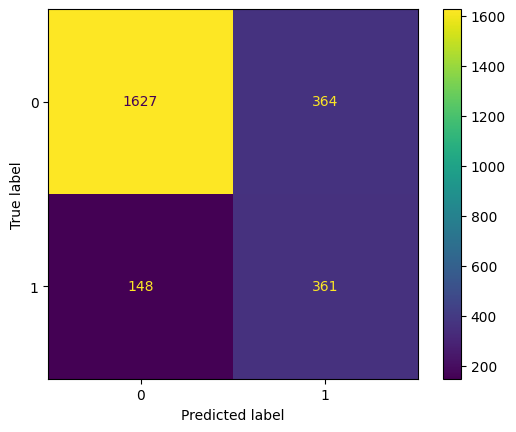

In [36]:
eval_hyperparams(study, X_test, y_test, X_train, y_train)

We can see that from the code above, the resulting classification yields good enough balanced accuracy. And if we saw from the sensitivity and specificity, while not as high as 0.90 it is still an improvement, as the baseline sensitivity (true positive rate) for imbalance if only predict all to be the positive class is the proportion of the positive class which is 0.20

## Training Model on The Whole Data and Saving It

In [37]:
def create_prod_model(study):
    sample_weights = compute_sample_weight(class_weight='balanced', y=y)
    # scale_pos_weight = y.value_counts()[0] / y.value_counts()[1]
    
    if study.best_params['classifier'] == 'lgbm':
        
        params = {
            'lgb_model__colsample_bytree': study.best_params['lgb_model__colsample_bytree'],
            'lgb_model__learning_rate': study.best_params['lgb_model__learning_rate'],
            'lgb_model__max_depth': study.best_params['lgb_model__max_depth'],
            'lgb_model__num_leaves': study.best_params['lgb_model__num_leaves'],
            'lgb_model__n_estimators': study.best_params['lgb_model__n_estimators'],
            'lgb_model__reg_alpha': study.best_params['lgb_model__reg_alpha'],
            'lgb_model__reg_lambda': study.best_params['lgb_model__reg_lambda'],
            'lgb_model__subsample': study.best_params['lgb_model__subsample'],
            'lgb_model__scale_pos_weight': study.best_params['lgb_model__scale_pos_weight']
        }
        
        clf_pipe = Pipeline(
            steps = [
                ('preprocessor', preprocess_pipeline),
                ('lgb_model', lgb.LGBMClassifier(device="gpu", random_state = 0, objective='binary', verbose = -1))
            ]
        )
        
        clf_pipe.set_params(**params)
        clf_pipe.fit(X, y, lgb_model__sample_weight = sample_weights)
    
    if study.best_params['classifier'] == 'rf':
        
        params = {
            'rf_model__bootstrap': study.best_params['rf_model__bootstrap'],
            'rf_model__class_weight': study.best_params['rf_model__class_weight'],
            'rf_model__max_depth': study.best_params['rf_model__max_depth'],
            'rf_model__max_features': study.best_params['rf_model__max_features'],
            'rf_model__max_leaf_nodes': study.best_params['rf_model__max_leaf_nodes'],
            'rf_model__criterion': study.best_params['rf_model__criterion'],
            'rf_model__n_estimators': study.best_params['rf_model__n_estimators']
        }
        
        clf_pipe = Pipeline(
            steps = [
                ('preprocessor', preprocess_pipeline),
                ('rf_model', RandomForestClassifier(random_state = 0, n_jobs = -1))
            ]
        )
        
        clf_pipe.set_params(**params)
        clf_pipe.fit(X, y, rf_model__sample_weight = sample_weights)

    return clf_pipe

## Saving The Pipeline as .pkl file

In [38]:
prod_pipe = create_prod_model(study)

In [40]:
timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
timestamp

'20240219203143'

In [41]:
joblib.dump(prod_pipe, f"{timestamp}.pkl", compress = 1)

['20240219203143.pkl']